### IMPORTS

---





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk

import tensorflow as tf

### DATASET

---



In [2]:
# this dataset doesn't containt labels for columns
columns = ["sentiment", "id", "date", "query", "user", "tweet"]

dataset = pd.read_csv("twitter.csv", 
                      header=None,
                      names=columns,
                      engine="python",
                      encoding="latin1",
                      error_bad_lines=False)

In [3]:
# get rid of unneccessary columns
dataset.drop(["id", "date", "query", "user"],
          axis=1,
          inplace=True)

In [4]:
dataset.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
dataset["sentiment"].unique()

array([0, 4, 2], dtype=int64)

In [6]:
# neutral sentiment - not needed
dataset.loc[dataset["sentiment"] == 2]

,sentiment,tweet
1600009,2,Check this video out -- President Obama at the...
1600029,2,need suggestions for a good IR filter for my c...
1600030,2,@surfit: I just checked my google for my busin...
1600044,2,is in San Francisco at Bay to Breakers.
1600045,2,just landed at San Francisco
...,...,...
1600474,2,has a date with bobby flay and gut fieri from ...
1600482,2,How to Track Iran with Social Media: http://bi...
1600485,2,Twitter Stock buzz: $AAPL $ES_F $SPY $SPX $PAL...
1600487,2,@johncmayer is Bobby Flay joining you?


In [7]:
dataset.drop(dataset.loc[dataset["sentiment"]==2].index, inplace=True)

In [8]:
# change labels
data_labels = dataset["sentiment"].values
data_labels[data_labels == 4] = 1

In [9]:
dataset["sentiment"].unique()

array([0, 1], dtype=int64)

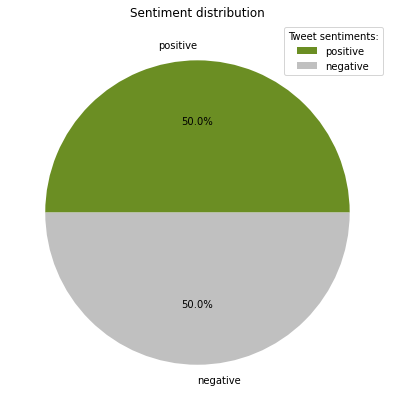

In [10]:
# check if the dataset is balanced
labels = ["positive", "negative"]
colors = ["olivedrab", "silver"]

plt.figure(figsize=(7,7))
plt.pie(dataset["sentiment"].value_counts(), labels=labels, colors=colors, autopct="%1.1f%%")
plt.legend(title = "Tweet sentiments:")
plt.title("Sentiment distribution")
plt.show()

### DATA PREPROCESSING

---



**PUNCTUATION AND OTHER JUNK**

---



In [11]:
from bs4 import BeautifulSoup

def clean_text(text):
    # xml info
    text = BeautifulSoup(text, "lxml").get_text()
    # tags @name
    text = re.sub(r"@[A-Za-z0-9]+", " ", text)
    # hyperlinks
    text = re.sub(r"https?://[A-Za-z0-9./]+", " ", text)
    # punctuation, except '
    text = re.sub(r"[^a-zA-Z']", " ", text)
    # double whitespaces
    text = re.sub(r" +", " ", text)
    # lower-case
    text = text.lower()
  
    return text

In [ ]:
data_clean = [clean_text(tweet) for tweet in dataset["tweet"]]

In [13]:
data_clean[:15]

[" awww that's a bummer you shoulda got david carr of third day to do it d",
 "is upset that he can't update his facebook by texting it and might cry as a result school today also blah ",
 ' i dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 " no it's not behaving at all i'm mad why am i here because i can't see you all over there ",
 ' not the whole crew ',
 'need a hug ',
 " hey long time no see yes rains a bit only a bit lol i'm fine thanks how's you ",
 " k nope they didn't have it ",
 ' que me muera ',
 "spring break in plain city it's snowing ",
 'i just re pierced my ears ',
 " i couldn't bear to watch it and i thought the ua loss was embarrassing ",
 ' it it counts idk why i did either you never talk to me anymore ',
 " i would've been the first but i didn't have a gun not really though zac snyder's just a doucheclown "]

**LEMMATIZATION & STOP WORD REMOVAL**

---



https://aclanthology.org/W18-5406.pdf

"In general, a simple tokenization works equally or better than more complex preprocessing techniques such as lemmatization or multiword grouping, except for domain-specific datasets (such as the medical dataset in our experiments) in which sole tokenization performs poorly" [44] 

--- 

Based on this, decided not to lemmatize, only tokenize and remove stop words 

In [ ]:
from nltk.corpus import stopwords

nltk.download("stopwords")

all_stopwords = stopwords.words("english")
# negation is important, don't even know why it's considered a stop word
all_stopwords.remove("not")

def remove_stopwords(text):
    # all words converted into a list of strings
    text = text.split()
    # checked and removed
    text = [word for word in text if not word in set(all_stopwords)]
    # joined back a single string
    text = " ".join(text)
    return text

In [15]:
corpus = [remove_stopwords(tweet) for tweet in data_clean]

In [16]:
corpus[:15]

["awww that's bummer shoulda got david carr third day",
 "upset can't update facebook texting might cry result school today also blah",
 'dived many times ball managed save rest go bounds',
 'whole body feels itchy like fire',
 "not behaving i'm mad can't see",
 'not whole crew',
 'need hug',
 "hey long time see yes rains bit bit lol i'm fine thanks how's",
 'k nope',
 'que muera',
 'spring break plain city snowing',
 'pierced ears',
 'bear watch thought ua loss embarrassing',
 'counts idk either never talk anymore',
 "would've first gun not really though zac snyder's doucheclown"]

**EMBEDDING**

---



In [41]:
# TENSORFLOW TOKENIZER -- to be used with CNN

from keras.preprocessing.text import Tokenizer

# consider using **args instead of manually cleaning data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [42]:
embedded_data = tokenizer.texts_to_sequences(corpus)

In [17]:
# BAG OF WORDS -- to be used with Naive Bayes

from sklearn.feature_extraction.text import CountVectorizer

# consider using **args instead of manually cleaning data
vectorizer = CountVectorizer(max_features=1000)
embedded_data = vectorizer.fit_transform(corpus)

In [18]:
embedded_data = embedded_data.toarray()

In [43]:
embedded_data[:5]

[[340, 66, 1055, 3342, 12, 740, 9547, 1749, 4],
 [664, 22, 434, 421, 1882, 192, 416, 2190, 69, 8, 170, 1000],
 [54943, 210, 245, 1107, 1543, 783, 360, 7, 23262],
 [319, 701, 372, 2746, 6, 1017],
 [2, 10117, 1, 482, 22, 21]]

**PADDING**

---



In [44]:
# pad to the longest tweet in the dataset
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max([len(tweet) for tweet in embedded_data])

padded_data = pad_sequences(embedded_data,
                            value=0,
                            padding="post",
                            maxlen=max_length)

In [45]:
padded_data[:5]

array([[  340,    66,  1055,  3342,    12,   740,  9547,  1749,     4,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  664,    22,   434,   421,  1882,   192,   416,  2190,    69,
            8,   170,  1000,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [54943,   210,   245,  1107,  1543,   783,   360,     7, 23262,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  319,   701,   372,  2746,     6,  1017,     0,     0,     0,
            0,     0,     0, 

### TRAIN/TEST/VALIDATION SPLIT

---



In [46]:
X = padded_data

y = dataset["sentiment"].to_numpy()

In [47]:
# check if shapes match
X.shape

(1600358, 37)

In [48]:
y.shape

(1600358,)

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size = 0.2, random_state = 5)

In [50]:
# second split for the validation set
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size = 0.5, random_state = 5)

In [51]:
X_train[:5]

array([[ 372,   20,  544,    8,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [ 605,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [1683,  152,   50, 1061, 2435,  412,   48,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  29,    2,  116,   69,  167,   38,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,

In [52]:
y_train[:5]

array([0, 1, 0, 0, 1], dtype=int64)

In [53]:
X_valid[:5]

array([[   782,   1933,      6,    206,     14,   4312,  14931,   1083,
             2,     47,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0],
       [   348, 100764,    203,      7,      9,    460,  22651,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0],
       [    31,    455,     22,      7,     46,   1725,     11,    101,
            65,     58,   2602,     24,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0

In [54]:
y_valid[:5]

array([1, 0, 1, 0, 1], dtype=int64)

In [55]:
X_test[:5]

array([[14319,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [   30,    15,   493,    15,     9,    38,    20,     5,   492,
           83,  4874,   447,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  940,   873,   126,  8338,   211,   435,   597,    29,   170,
         2209,   349,    40,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  324,    56,     2,    54,  1533, 22383,  1519,  1607,  1381,
         2014,  1614,   115, 

In [56]:
y_test[:5]

array([0, 0, 0, 0, 0], dtype=int64)

### NEW DATA

---



In [57]:
# TENSORFLOW TOKENIZER -- to be used with CNN

def new_data_cleanup(data):
    data = clean_text(data)
    data = tokenizer.texts_to_sequences(data)
    data = pad_sequences(data,
                        value=0,
                        padding="post",
                        maxlen=max_length)
    return data

In [33]:
# BAG OF WORDS -- to be used with Naive Bayes

def new_data_cleanup(data):
    data = vectorizer.transform([data])
    data = data.toarray()
    data = pad_sequences(data,
                            value=0,
                            padding="post",
                            maxlen=max_length)
    return data

In [58]:
# for final predictions
new_tweet = "I think @Mary is the hottest girl around!"
new_tweet = new_data_cleanup(new_tweet)

### SIMPLE NAIVE BAYES

**MODEL CONFIGURATION**

---



In [35]:
from sklearn.naive_bayes import MultinomialNB

bayes_classifier = MultinomialNB()

**MODEL TRAINING**

---



In [36]:
bayes_classifier.fit(X_train, y_train)

MultinomialNB()

**MODEL EVALUATION**

---



In [37]:
y_pred = bayes_classifier.predict(X_test)

In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.73      0.74     80083
           1       0.73      0.75      0.74     79953

    accuracy                           0.74    160036
   macro avg       0.74      0.74      0.74    160036
weighted avg       0.74      0.74      0.74    160036



**NEW PREDICTIONS**

---



In [39]:
output = bayes_classifier.predict(new_tweet)

def prediction(output):
   if output[0] == 1:
     return "positive"
   else:
     return "negative"

In [40]:
prediction(output)

'positive'

### CONVOLUTIONAL NEURAL NETWORK

**MODEL CONFIGURATION**

---



In [59]:
from keras.models import Sequential
from keras.layers import Input, Embedding, Conv1D, MaxPool1D, GlobalMaxPool1D, Dense, Dropout, BatchNormalization

In [60]:
INPUT_SHAPE = X_train.shape[1]
VOCABULARY_SIZE = len(tokenizer.word_index)
EMBEDDING_DIMENSION = 32
FILTERS = 16
DROPOUT_RATE = 0.3
FFN_UNITS = 32

In [61]:
cnn = Sequential()

cnn.add(Input(INPUT_SHAPE,))
# +1 here resolves the indexing problem during training
cnn.add(Embedding(VOCABULARY_SIZE+1, EMBEDDING_DIMENSION))

cnn.add(Conv1D(filters=FILTERS, kernel_size=2, activation="relu"))
cnn.add(BatchNormalization())
cnn.add(MaxPool1D())
cnn.add(Dropout(DROPOUT_RATE))

cnn.add(Conv1D(filters=FILTERS, kernel_size=4, activation="relu"))
cnn.add(BatchNormalization())
cnn.add(GlobalMaxPool1D())
cnn.add(Dropout(DROPOUT_RATE*2))

cnn.add(Dense(units=FFN_UNITS, activation="relu"))
cnn.add(BatchNormalization())
cnn.add(Dropout(DROPOUT_RATE*3))

# if number of classes == 2, units=1, activation="sigmoid", else number of classes == units, activation="softmax"
cnn.add(Dense(units=1, activation="sigmoid"))

In [62]:
# if number of classes == 2, loss="binary_crossentropy", else "sparse_categorical_crossentropy", metrics="sparse_categorical_accuracy", for example
cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [63]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 37, 32)            9444288   
                                                                 
 conv1d (Conv1D)             (None, 36, 16)            1040      
                                                                 
 batch_normalization (BatchN  (None, 36, 16)           64        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 16)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 18, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 16)            1

**MODEL TRAINING**

---



In [64]:
BATCH_SIZE = 100
EPOCHS = 10

In [65]:
# stop after 2 epochs of no improvement of loss
stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 2)

In [66]:
cnn.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_valid, y_valid), batch_size=BATCH_SIZE, callbacks=[stop])

Epoch 1/10
12803/12803 [==============================] - 1253s 98ms/step - loss: 0.6057 - accuracy: 0.6926 - val_loss: 0.4787 - val_accuracy: 0.7811
Epoch 2/10
12803/12803 [==============================] - 1288s 101ms/step - loss: 0.5210 - accuracy: 0.7667 - val_loss: 0.4630 - val_accuracy: 0.7884
Epoch 3/10
12803/12803 [==============================] - 1231s 96ms/step - loss: 0.5028 - accuracy: 0.7800 - val_loss: 0.4587 - val_accuracy: 0.7902
Epoch 4/10
12803/12803 [==============================] - 1239s 97ms/step - loss: 0.4906 - accuracy: 0.7889 - val_loss: 0.4561 - val_accuracy: 0.7892
Epoch 5/10
12803/12803 [==============================] - 1287s 101ms/step - loss: 0.4801 - accuracy: 0.7960 - val_loss: 0.4580 - val_accuracy: 0.7870
Epoch 6/10
12803/12803 [==============================] - 1291s 101ms/step - loss: 0.4720 - accuracy: 0.8016 - val_loss: 0.4581 - val_accuracy: 0.7879


**MODEL EVALUATION**

---



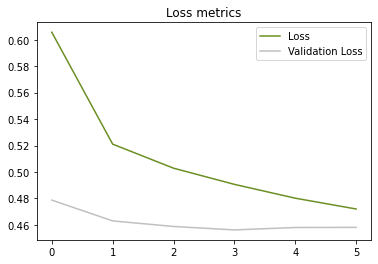

In [68]:
plt.plot(cnn.history.history["loss"], label="Loss", color=colors[0] )
plt.plot(cnn.history.history["val_loss"], label="Validation Loss", color=colors[1])
plt.title("Loss metrics")
plt.legend()
plt.show()

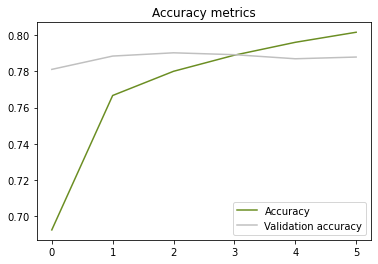

In [69]:
plt.plot(cnn.history.history["accuracy"], label="Accuracy", color=colors[0])
plt.plot(cnn.history.history["val_accuracy"], label="Validation accuracy", color=colors[1])
plt.title("Accuracy metrics")
plt.legend()
plt.show()

In [70]:
cnn.evaluate(X_test, y_test, verbose=1)

5002/5002 [==============================] - 3s 615us/step - loss: 0.4601 - accuracy: 0.7874


[0.46011799573898315, 0.7873603701591492]

In [ ]:
cnn.save('saved_model/twitter_model')

In [ ]:
#cnn = tf.keras.models.load_model('saved_model/twitter_model')

**NEW PREDICTIONS**

---



In [73]:
output = cnn.predict(new_tweet)

In [74]:
def prediction(output):
   if output[0][0] > 0.5:
     return "positive"
   else:
     return "negative"

In [75]:
prediction(output)

'positive'